## Introduction: Business Problem

This project identifies and recommends the nearest schools and school categories in neighborhoods. People especially families may move from one settlement to the other without considering the status of schools and their categories within the city and its neighborhoods.

The project targets families and students who will need to consider schools and their categories within the neighborhoods of a city before making their choices of settlement.

With regards to development and building of school structures in a city, the government will need to analyze schools and their categories within the neighborhoods to make the best choices for residents.

Private sectors, investors and business institutions are also beneficiaries. These entities can secure the right locations to invest by making the right decision on which categories of schools will be of a high demand in various neighborhoods.


## Data:

Based on the problem definition above, factors to be considered are:
*	Number of schools and their categories in a neighborhood
*	Radius distance of neighborhoods nearest to schools

The following data sources will be required to extract relevant data:
*	A list of neighborhoods of Manchester from Wikipedia
*	A geocoder library for extracting latitude and longitude coordinates
*	FourSquare API for searching for schools within these neighborhoods and providing their various latitudes and longitude coordinates


In [92]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import html5lib
from bs4 import BeautifulSoup

from urllib import request
import ssl

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# !pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [93]:
def best_k_cluster(data_transformed, range_limit):
    Sum_of_squared_distances = []
    K = range(1,range_limit)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data_transformed)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [94]:
# url = "https://www.tourismincapetown.co.za/postalcodes_results.php?value=j"
# context = ssl._create_unverified_context()
# response = request.urlopen(url, context=context)
# html = response.read()

df_neighbour_tables = pd.read_html("https://en.wikipedia.org/wiki/M_postcode_area")

In [117]:
df_neighbours = df_neighbour_tables[1]

In [118]:
# Rename the column of df_neighbours
df_neighbours = df_neighbours.rename(columns = {'Postcode district': 'PostalCode', 'Post town': 'Town', 'Coverage': 'Neighborhood'}, inplace = False)

df_neighbours.head()

,PostalCode,Town,Neighborhood,Local authority area(s)
0,M1,MANCHESTER,"Piccadilly, City Centre, Market Street",Manchester
1,M2,MANCHESTER,"Deansgate, City Centre",Manchester
2,"M3(Sectors 1, 2, 3, 4 and 9)",MANCHESTER,"City Centre, Deansgate, Castlefield",Manchester
3,"M3(Sectors 5, 6 and 7)",SALFORD,"Blackfriars, Greengate, Trinity",Salford
4,M4,MANCHESTER,"Ancoats, Northern Quarter, Strangeways",Manchester


In [119]:
df_neighbours.shape
df_neighbours.tail(10)

,PostalCode,Town,Neighborhood,Local authority area(s)
42,M50,SALFORD,"Salford Quays, MediaCityUK",Salford
43,M60(Sectors 1 and 7),MANCHESTER,Large user and PO Box (located geographically ...,Manchester
44,M60(Sectors 2 and 8),MANCHESTER,Large user and PO Box (located geographically ...,Manchester
45,M60(Sectors 3 and 9),MANCHESTER,Large user and PO Box (located geographically ...,Manchester
46,M60(Sectors 4 and 0),MANCHESTER,Large user and PO Box (located geographically ...,Manchester
47,M60(Sectors 5 and 6),MANCHESTER,Manchester X,Manchester
48,M60(Sector 9),SALFORD,Large user and PO Box,Salford
49,M61,MANCHESTER,Manchester X,Manchester
50,M90,MANCHESTER,Manchester Airport,Manchester
51,M99,MANCHESTER,Manchester X; JD Williams (located geographica...,Manchester


In [120]:
# df_neighbours = df_neighbours[df_neighbours.PostalCode[0:3] != "M60"]
# df_neighbours.tail(10)
for index, row in df_neighbours.iterrows():
    if (row.PostalCode[0:3] == "M60"):
        print("Passed...")
        df_neighbours.drop([index], axis=0, inplace=True)

df_neighbours.drop([2,3,51], axis=0, inplace=True)
df_neighbours.tail(10)

# df_neighbours.head()

Passed...
Passed...
Passed...
Passed...
Passed...
Passed...


,PostalCode,Town,Neighborhood,Local authority area(s)
35,M38,MANCHESTER,Little Hulton,Salford
36,M40,MANCHESTER,"Collyhurst, Miles Platting, Moston, New Moston...",Manchester
37,M41,MANCHESTER,"Urmston, Davyhulme, Flixton, Trafford Park",Trafford
38,M43,MANCHESTER,Droylsden,Tameside
39,M44,MANCHESTER,"Irlam, Cadishead",Salford
40,M45,MANCHESTER,Whitefield,Bury
41,M46,MANCHESTER,Atherton,Wigan
42,M50,SALFORD,"Salford Quays, MediaCityUK",Salford
49,M61,MANCHESTER,Manchester X,Manchester
50,M90,MANCHESTER,Manchester Airport,Manchester


In [121]:
df_neighbours.shape

(43, 4)

In [215]:
df_neighbours = df_neighbours.reset_index(drop=True)
df_neighbours.head()

,PostalCode,Town,Neighborhood,Local authority area(s)
0,M1,Manchester,"Piccadilly, City Centre, Market Street",Manchester
1,M2,Manchester,"Deansgate, City Centre",Manchester
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",Manchester
3,M5,Salford,"Ordsall, Seedley, Weaste, University",Salford
4,M6,Salford,"Pendleton, Irlams o' th' Height, Langworthy, S...",Salford


In [123]:
for index, row in df_neighbours.iterrows():
    row["Town"] = row["Town"].replace(row["Town"],row["Town"].capitalize())
    # print (row["Neighbourhood"])
df_neighbours.head()


,PostalCode,Town,Neighborhood,Local authority area(s)
0,M1,Manchester,"Piccadilly, City Centre, Market Street",Manchester
1,M2,Manchester,"Deansgate, City Centre",Manchester
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",Manchester
3,M5,Salford,"Ordsall, Seedley, Weaste, University",Salford
4,M6,Salford,"Pendleton, Irlams o' th' Height, Langworthy, S...",Salford


In [124]:

def lat_lng_coordinates(town, neighood):
    lat_lng_coords = None
    count=0
    neighood_arr = neighood.split(sep=",", maxsplit=2)
    print(neighood_arr[0])
    if len(town) > 0 and len(neighood) > 0:
        print("Both")
        address = "{}, {}".format(town, neighood_arr[0])
    elif len(town) > 0:
        print("town")
        address = "{}".format(town)
    elif len(neighood) > 0:
        print("Neighborhood")
        address = "{}".format(neighood_arr[0])
    else:
        print("None")
        address = ""

    while(lat_lng_coords is None):
        print('2')
        # geolocator = Nominatim(user_agent="ny_explorer")
        geolocator = Nominatim(user_agent="foursquare_agent")
        lat_lng_coords = geolocator.geocode(address)
    latd = lat_lng_coords.latitude
    lngd = lat_lng_coords.longitude
    count=count+1
    print([latd, lngd])
    return [latd, lngd]
# lat_lng_coordinates('Manchester', 'Droylsden')


In [125]:
# define the dataframe columns
column_names = ['PostalCode', 'Town', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [126]:
for index, row in df_neighbours.iterrows():
    print("===={}.".format(index + 1))
    postal_code = row["PostalCode"]
    town = neighborhood_name = row["Town"]
    neighborhood_name = row["Neighborhood"]

        
    neighborhood_latlon = lat_lng_coordinates(town, neighborhood_name)
    neighborhood_lat = neighborhood_latlon[0]
    neighborhood_lon = neighborhood_latlon[1]
    
    neighborhoods = neighborhoods.append({'PostalCode': postal_code,'Town': town,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

====1.
Piccadilly
Both
2
[53.4793964, -2.2317427]
====2.
Deansgate
Both
2
[53.4740961, -2.251063]
====3.
Ancoats
Both
2
[53.4849976, -2.2276032]
====4.
Ordsall
Both
2
[53.4739114, -2.2780967]
====5.
Pendleton
Both
2
[53.4892329, -2.2841576]
====6.
Higher Broughton
Both
2
[53.5081154, -2.264094]
====7.
Crumpsall
Both
2
[53.5209118, -2.2416946]
====8.
Harpurhey
Both
2
[53.5119068, -2.2084489]
====9.
Clayton
Both
2
[53.47909565, -2.1737927145538274]
====10.
Ardwick
Both
2
[53.4676745, -2.2160104]
====11.
Ardwick
Both
2
[53.4676745, -2.2160104]
====12.
Fallowfield
Both
2
[53.4449381, -2.2217207]
====13.
Hulme
Both
2
[53.4660305, -2.2481663]
====14.
Firswood
Both
2
[53.4512279, -2.2776656]
====15.
Trafford Park
Both
2
[53.4717516, -2.3209276]
====16.
Abbey Hey
Both
2
[53.4698583, -2.1521982492134226]
====17.
Levenshulme
Both
2
[53.4443366, -2.1931527]
====18.
Didsbury
Both
2
[53.4168134, -2.2321381]
====19.
Chorlton-cum-Hardy
Both
2
[53.4425082, -2.2772108]
====20.
Wythenshawe
Both
2
[53.38

In [127]:
neighborhoods.head()

,PostalCode,Town,Neighborhood,Latitude,Longitude
0,M1,Manchester,"Piccadilly, City Centre, Market Street",53.479396,-2.231743
1,M2,Manchester,"Deansgate, City Centre",53.474096,-2.251063
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",53.484998,-2.227603
3,M5,Salford,"Ordsall, Seedley, Weaste, University",53.473911,-2.278097
4,M6,Salford,"Pendleton, Irlams o' th' Height, Langworthy, S...",53.489233,-2.284158


In [128]:
manchester_nh_df = neighborhoods[neighborhoods['Town'] == 'Manchester'].reset_index(drop=True)
manchester_nh_df.head()

,PostalCode,Town,Neighborhood,Latitude,Longitude
0,M1,Manchester,"Piccadilly, City Centre, Market Street",53.479396,-2.231743
1,M2,Manchester,"Deansgate, City Centre",53.474096,-2.251063
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",53.484998,-2.227603
3,M8,Manchester,"Crumpsall, Cheetham Hill",53.520912,-2.241695
4,M9,Manchester,"Harpurhey, Blackley",53.511907,-2.208449


In [129]:
# create map of Toronto using latitude and longitude values

latitude = manchester_nh_df.loc[0, 'Latitude']
longitude = manchester_nh_df.loc[0, 'Longitude']
map_manchester = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, town, neighborhood in zip(manchester_nh_df['Latitude'], manchester_nh_df['Longitude'], manchester_nh_df['Town'], manchester_nh_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manchester)  
    
map_manchester

In [130]:
CLIENT_ID = 'L3FFB4L5XCCYSXC0TDKGOLKPCGSDQYH5IIBJRB13OJRX3T4H' # your Foursquare ID
CLIENT_SECRET = 'FNB2D0Q2YLKDYWRRG4ONEUGZJ23BMPQ5NLDJAQMJ2FFLYXOY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: L3FFB4L5XCCYSXC0TDKGOLKPCGSDQYH5IIBJRB13OJRX3T4H
CLIENT_SECRET:FNB2D0Q2YLKDYWRRG4ONEUGZJ23BMPQ5NLDJAQMJ2FFLYXOY


In [131]:
manchester_nh_df.loc[26, 'Neighborhood']

'Stretford'

In [132]:
# Get the neighborhood's latitude and longitude values
neighborhood_latitude = manchester_nh_df.loc[26, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manchester_nh_df.loc[26, 'Longitude'] # neighborhood longitude value
neighborhood_name = manchester_nh_df.loc[26, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
# print("Glory")

Latitude and longitude values of Stretford are 53.445428, -2.3223051.


In [133]:
# type your answer here

#The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
search_query='School' # search query string

column_names=['Neighborhood','Latitude','Longitude','School','Sch_Latitude','Sch_Longitude','Sch_Category']
sch_nh_df = pd.DataFrame(columns=column_names)
tmp_name = None
for name, lat, lng in zip(manchester_nh_df['Neighborhood'],manchester_nh_df['Latitude'],manchester_nh_df['Longitude']):
    
    if tmp_name == name:
        print("OUT ====== {}".format(name))
        pass
    else:
        print(name)
        tmp_name = name
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        search_query, 
        radius, 
        LIMIT)

        # make the GET request and examine results
        results = requests.get(url).json()
        sch_venues = results['response']['venues']
        for school in sch_venues:
            if len(school['categories'])>0:
                sch_nh_df = sch_nh_df.append({'Neighborhood':name,'Latitude':lat,'Longitude':lng,'School':school['name'],'Sch_Latitude':school['location']['lat'],'Sch_Longitude':school['location']['lng'],'Sch_Category':school['categories'][0]['name']},ignore_index=True)
            else:
                sch_nh_df = sch_nh_df.append({'Neighborhood':name,'Latitude':lat,'Longitude':lng,'School':school['name'],'Sch_Latitude':school['location']['lat'],'Sch_Longitude':school['location']['lng'],'Sch_Category':'Not Stated'},ignore_index=True)
            

Piccadilly, City Centre, Market Street
Deansgate, City Centre
Ancoats, Northern Quarter, Strangeways
Crumpsall, Cheetham Hill
Harpurhey, Blackley
Clayton, Openshaw, Beswick
Ardwick, Longsight, Chorlton-on-Medlock
OUT ====== Ardwick, Longsight, Chorlton-on-Medlock
Fallowfield, Moss Side, Ladybarn, Rusholme, Victoria Park, Longsight
Hulme, Manchester Science Park, Old Trafford
Firswood, Old Trafford, Whalley Range, Moss Side
Trafford Park, The Trafford Centre
Abbey Hey, Gorton
Levenshulme, Burnage
Didsbury, Withington
Chorlton-cum-Hardy, Barlow Moor
Wythenshawe, Northenden, Sharston Industrial Area
Baguley, Brooklands (Manchester and Trafford), Roundthorn Industrial Estate
Middleton, Alkrington, Chadderton
Prestwich, Sedgley Park, Simister
Radcliffe, Stoneclough
Swinton, Clifton, Pendlebury, Wardley, Agecroft
Worsley, Walkden, Boothstown, Mosley Common, Wardley Industrial Estate
Tyldesley, Astley
Eccles, Monton, Peel Green, Winton, Patricroft, Barton-upon-Irwell, Ellesmere Park
Carringto

In [134]:
# Let's check the size of the resulting dataframe
print(sch_nh_df.shape)
sch_nh_df1 = sch_nh_df
sch_nh_df.head()

(356, 7)


,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude,Sch_Category
0,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Communicate School of English,53.481999,-2.239409,Language School
1,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,A2Z School of English,53.479104,-2.241445,Student Center
2,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"Sandra Burslem Building, Manchester Metropolit...",53.471157,-2.240015,Law School
3,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchester Met Business School,53.470494,-2.239897,College Academic Building
4,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Chetham's School Of Music,53.486594,-2.243361,School


In [135]:
# Group by School and School Category(Sch_Category) to identify the list of Schools and Categories which are irrelevant and needs replacement and removal.

# sch_nh_df_group = sch_nh_df.groupby('School').count()
# sch_nh_df_group = sch_nh_df.groupby('Neighborhood').count()
# sch_nh_df_group = sch_nh_df.groupby('Sch_Latitude').count()
sch_nh_df_group = sch_nh_df.groupby('Sch_Category').count()
sch_nh_df_group.head(10)

,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude
Sch_Category,,,,,,
Accessories Store,1,1,1,1,1,1
Art Gallery,2,2,2,2,2,2
Breakfast Spot,1,1,1,1,1,1
Business Service,1,1,1,1,1,1
Café,7,7,7,7,7,7
College & University,2,2,2,2,2,2
College Academic Building,41,41,41,41,41,41
College Arts Building,6,6,6,6,6,6
College Auditorium,3,3,3,3,3,3


In [136]:

# Category Replacement
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Soccer Field",case=False)]
sch_nh_df1.loc[(sch_nh_df1.School.str.contains('Primary',case=False)),'Sch_Category'] = "Elementary School"
sch_nh_df1.loc[(sch_nh_df1.Sch_Category.str.contains('University',case=False)),'Sch_Category'] = 'University'

sch_nh_df1.loc[(sch_nh_df1.Sch_Category.str.contains('Middle School',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Private School',case=False)),'Sch_Category'] = 'Elementary School'

sch_nh_df1.loc[(sch_nh_df1.School.str.contains('Nursery',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Preschool',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Nursery',case=False)) | (sch_nh_df1.School.str.contains('Pre-school',case=False)),'Sch_Category'] = 'Pre School'

sch_nh_df1.loc[(sch_nh_df1.School.str.contains('Law School',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Law School',case=False)),'Sch_Category'] = "Law School"

sch_nh_df1.loc[(sch_nh_df1.School.str.contains('High School',case=False)) | (sch_nh_df1.Sch_Category.str.contains('High School',case=False)),'Sch_Category'] = "High School"


sch_nh_df1.loc[(sch_nh_df1.Sch_Category.str.contains('Shop',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Dance',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Studio',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Pool',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Store',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Trade',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Entertainment',case=False)) | (sch_nh_df1.Sch_Category.str.contains('Theater',case=False)),'Sch_Category'] = "Vocational & Arts"

sch_nh_df1.head(10)


,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude,Sch_Category
0,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Communicate School of English,53.481999,-2.239409,Language School
1,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,A2Z School of English,53.479104,-2.241445,Student Center
2,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"Sandra Burslem Building, Manchester Metropolit...",53.471157,-2.240015,Law School
3,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchester Met Business School,53.470494,-2.239897,College Academic Building
4,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Chetham's School Of Music,53.486594,-2.243361,School
5,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchest School of Theatre,53.470090,-2.236934,Vocational & Arts
6,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchester School of Architecture,53.480126,-2.232352,Office
7,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"School of Mechanical, Aerospace & Civil Engine...",53.474850,-2.233708,College Auditorium
8,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School of Electrical and Electronic Engineering,53.476001,-2.235603,Not Stated
9,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School Of Civil Engineering University Of Manc...,53.474792,-2.234869,College Academic Building


In [137]:
print(sch_nh_df1.shape)
#Irrelevant data Removal
# Bus, Raspberrypi4schools.com, Lane, Cafe, Common Room
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.School.str.contains("Bus",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.School.str.contains("Raspberrypi4schools.com",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.School.str.contains("Lane",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.School.str.contains("Cafe",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.School.str.contains("Common Room",case=False)]

# Road, Office, Field, Café, Gym, Service, Hotel, Spot, # Art Gallery, Community Center, Event Space, Student Center
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Road",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Office",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Venue",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Spot",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Gym",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Service",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Hotel",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Café",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Art Gallery",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Community Center",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Event Space",case=False)]
sch_nh_df1 = sch_nh_df1[~sch_nh_df1.Sch_Category.str.contains("Student Center",case=False)]



sch_nh_df1.loc[sch_nh_df1.Sch_Category.str.contains('College',case=False),'Sch_Category']='Not Stated'

# mydf1.loc[~((mydf1.School_category.str.contains('Not Mentioned',case=False))|(mydf1.School_category.str.contains('High School',case=False))|(mydf1.School_category.str.contains('Student Center',case=False))|mydf1.School_category.str.contains('Primary/Play',case=False)),'School_category']='Not Mentioned'
print(sch_nh_df1.shape)
sch_nh_df1.head(50)

(354, 7)
(293, 7)


,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude,Sch_Category
0,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Communicate School of English,53.481999,-2.239409,Language School
2,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"Sandra Burslem Building, Manchester Metropolit...",53.471157,-2.240015,Law School
4,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Chetham's School Of Music,53.486594,-2.243361,School
5,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchest School of Theatre,53.470090,-2.236934,Vocational & Arts
7,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"School of Mechanical, Aerospace & Civil Engine...",53.474850,-2.233708,Not Stated
8,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School of Electrical and Electronic Engineering,53.476001,-2.235603,Not Stated
9,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School Of Civil Engineering University Of Manc...,53.474792,-2.234869,Not Stated
10,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School of MACE,53.473196,-2.234606,Not Stated
11,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,School of Chemical And Analytical Science,53.475166,-2.236502,Not Stated
12,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Big Word School,53.477437,-2.234624,Not Stated


In [138]:
for index, row in sch_nh_df1.iterrows():
    if row["Sch_Category"] == "School":
        sch_nh_df1.at[index, "Sch_Category"] = "Not Stated"
sch_nh_df1.head()

,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude,Sch_Category
0,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Communicate School of English,53.481999,-2.239409,Language School
2,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"Sandra Burslem Building, Manchester Metropolit...",53.471157,-2.240015,Law School
4,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Chetham's School Of Music,53.486594,-2.243361,Not Stated
5,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchest School of Theatre,53.470090,-2.236934,Vocational & Arts
7,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"School of Mechanical, Aerospace & Civil Engine...",53.474850,-2.233708,Not Stated


In [139]:
sch_nh_df1 = sch_nh_df1.drop_duplicates(subset=['Sch_Latitude','Sch_Longitude'],
                                       keep='first').reset_index(drop=True)
sch_nh_df1.shape

(183, 7)

In [140]:
sch_nh_df1.head()

,Neighborhood,Latitude,Longitude,School,Sch_Latitude,Sch_Longitude,Sch_Category
0,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Communicate School of English,53.481999,-2.239409,Language School
1,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"Sandra Burslem Building, Manchester Metropolit...",53.471157,-2.240015,Law School
2,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Chetham's School Of Music,53.486594,-2.243361,Not Stated
3,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,Manchest School of Theatre,53.470090,-2.236934,Vocational & Arts
4,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,"School of Mechanical, Aerospace & Civil Engine...",53.474850,-2.233708,Not Stated


In [141]:
# create map of Manchester City using latitude and longitude values

# Latitude and Longitude for the Manchester City/Town 
manchester_lat = 53.48095
manchester_lng = -2.23743
manchester_sch_map = folium.Map(location=[manchester_lat, manchester_lng], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, school, sch_category in zip(sch_nh_df1['Sch_Latitude'], sch_nh_df1['Sch_Longitude'], sch_nh_df1['Neighborhood'], sch_nh_df1['School'], sch_nh_df1['Sch_Category']):
    label = '{}:({}); {}'.format(school, sch_category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        icon=folium.Icon(color='red',icon='university', prefix='fa'),
        parse_html=False).add_to(manchester_sch_map)  
    
# display map
manchester_sch_map

In [142]:
# Let's find out how many unique categories can be curated from all the returned schools

print('There are {} unique categories.'.format(len(sch_nh_df1['Sch_Category'].unique())))

There are 10 unique categories.


In [143]:
sch_cat_group = sch_nh_df1.groupby('Sch_Category').count().reset_index()
sch_cat_group['Sch_Category']=sch_cat_group['Sch_Category'].astype(str)
sch_cat_group.shape

(10, 7)

<AxesSubplot:>

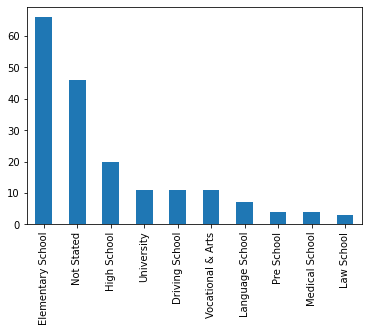

In [144]:
sch_nh_df1['Sch_Category'].value_counts().plot(kind='bar')

## Analyze Each Neighborhood and School Category

In [145]:
# one hot encoding
manchester_onehot = pd.get_dummies(sch_nh_df1[['Sch_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manchester_onehot['Neighborhood'] = sch_nh_df1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manchester_onehot.columns[-1]] + list(manchester_onehot.columns[:-1])
manchester_onehot = manchester_onehot[fixed_columns]

manchester_onehot.head()

,Neighborhood,Driving School,Elementary School,High School,Language School,Law School,Medical School,Not Stated,Pre School,University,Vocational & Arts
0,"Piccadilly, City Centre, Market Street",0,0,0,1,0,0,0,0,0,0
1,"Piccadilly, City Centre, Market Street",0,0,0,0,1,0,0,0,0,0
2,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,1,0,0,0
3,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,1
4,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,1,0,0,0


In [146]:
# Dataframe size

manchester_onehot.shape

(183, 11)

In [147]:
manchester_grouped = manchester_onehot.groupby('Neighborhood').mean().reset_index()
manchester_grouped

,Neighborhood,Driving School,Elementary School,High School,Language School,Law School,Medical School,Not Stated,Pre School,University,Vocational & Arts
0,"Abbey Hey, Gorton",0.000000,0.833333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Ancoats, Northern Quarter, Strangeways",0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Ardwick, Longsight, Chorlton-on-Medlock",0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
3,Atherton,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000
4,"Baguley, Brooklands (Manchester and Trafford),...",0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Chorlton-cum-Hardy, Barlow Moor",0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Clayton, Openshaw, Beswick",0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000
7,"Collyhurst, Miles Platting, Moston, New Moston...",0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Crumpsall, Cheetham Hill",0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Deansgate, City Centre",0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.428571,0.000000


In [148]:
# New Size

manchester_grouped.shape

(33, 11)

In [149]:
num_top_schools = 5

for hood in manchester_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manchester_grouped[manchester_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['School category','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_schools))
    print('\n')

----Abbey Hey, Gorton----
     School category  Frequency
0  Elementary School       0.83
1        High School       0.17
2     Driving School       0.00
3    Language School       0.00
4         Law School       0.00


----Ancoats, Northern Quarter, Strangeways----
     School category  Frequency
0  Elementary School        1.0
1     Driving School        0.0
2        High School        0.0
3    Language School        0.0
4         Law School        0.0


----Ardwick, Longsight, Chorlton-on-Medlock----
     School category  Frequency
0         Not Stated        0.8
1  Elementary School        0.2
2     Driving School        0.0
3        High School        0.0
4    Language School        0.0


----Atherton----
     School category  Frequency
0         Not Stated        0.6
1  Elementary School        0.4
2     Driving School        0.0
3        High School        0.0
4    Language School        0.0


----Baguley, Brooklands (Manchester and Trafford), Roundthorn Industrial Estate----
  

### Let's put that into a *pandas* dataframe

In [150]:
# First, let's write a function to sort the schools in descending order.

def return_most_common_schools(row, num_top_schools):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_schools]

#### Now let's create the new dataframe and display the top 10 School Categories for each neighborhood.

In [151]:
import numpy as np # library to handle data in a vectorized manner

num_top_schools = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top schools
columns = ['Neighborhood']
for ind in np.arange(num_top_schools):
    try:
        columns.append('{}{} Most Common Sch. Cat'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Sch. Cat'.format(ind+1))

# create a new dataframe
neighborhoods_school_cats_sorted = pd.DataFrame(columns=columns)
neighborhoods_school_cats_sorted['Neighborhood'] = manchester_grouped['Neighborhood']

for ind in np.arange(manchester_grouped.shape[0]):
    neighborhoods_school_cats_sorted.iloc[ind, 1:] = return_most_common_schools(manchester_grouped.iloc[ind, :], num_top_schools)

neighborhoods_school_cats_sorted.head(7)

,Neighborhood,1st Most Common Sch. Cat,2nd Most Common Sch. Cat,3rd Most Common Sch. Cat,4th Most Common Sch. Cat,5th Most Common Sch. Cat,6th Most Common Sch. Cat,7th Most Common Sch. Cat,8th Most Common Sch. Cat,9th Most Common Sch. Cat,10th Most Common Sch. Cat
0,"Abbey Hey, Gorton",Elementary School,High School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
1,"Ancoats, Northern Quarter, Strangeways",Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School,Driving School
2,"Ardwick, Longsight, Chorlton-on-Medlock",Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
3,Atherton,Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
4,"Baguley, Brooklands (Manchester and Trafford),...",High School,Elementary School,Driving School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School
5,"Chorlton-cum-Hardy, Barlow Moor",High School,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
6,"Clayton, Openshaw, Beswick",Elementary School,Not Stated,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School


## Cluster Neighborhoods for School Categories

Run *k*-means to cluster the neighborhood into 4 clusters.

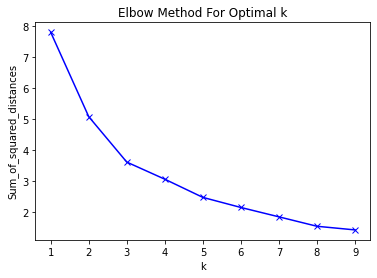

In [153]:
# Calculate the best K cluster number for the Clustering of School Categories
manchester_grouped_clustering = manchester_grouped.drop('Neighborhood', 1)

best_k_cluster(manchester_grouped_clustering, 10)

In [154]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manchester_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 2, 2, 0, 0, 2, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 school categories for each neighborhood.

In [155]:
# add clustering labels
neighborhoods_school_cats_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
# neighborhoods_schools_sorted = neighborhoods_schools_sorted.assign(Cluster_Labels = kmeans.labels_.astype(int))

manchester_merged = manchester_nh_df

# merge manchester_grouped with manchester_nh_df to add latitude/longitude for each neighborhood
manchester_merged = manchester_merged.join(neighborhoods_school_cats_sorted.set_index('Neighborhood'), on='Neighborhood')

manchester_merged.head() # check the last columns!

,PostalCode,Town,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Sch. Cat,2nd Most Common Sch. Cat,3rd Most Common Sch. Cat,4th Most Common Sch. Cat,5th Most Common Sch. Cat,6th Most Common Sch. Cat,7th Most Common Sch. Cat,8th Most Common Sch. Cat,9th Most Common Sch. Cat,10th Most Common Sch. Cat
0,M1,Manchester,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,1.0,Not Stated,Vocational & Arts,University,Language School,Law School,Elementary School,Driving School,Pre School,Medical School,High School
1,M2,Manchester,"Deansgate, City Centre",53.474096,-2.251063,1.0,University,Not Stated,Elementary School,Vocational & Arts,Pre School,Medical School,Law School,Language School,High School,Driving School
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",53.484998,-2.227603,0.0,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School,Driving School
3,M8,Manchester,"Crumpsall, Cheetham Hill",53.520912,-2.241695,2.0,High School,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
4,M9,Manchester,"Harpurhey, Blackley",53.511907,-2.208449,0.0,Elementary School,University,Not Stated,Vocational & Arts,Pre School,Medical School,Law School,Language School,High School,Driving School


In [156]:
# manchester_merged = manchester_merged.astype({"Cluster Labels": int})
# manchester_merged

### Finally, let's visualize the resulting clusters on the map of Manchester

In [159]:
# create map
import math
# Latitude and Longitude for the Manchester City/Town 
manchester_lat = 53.48095
manchester_lng = -2.23743
map_clusters = folium.Map(location=[manchester_lat, manchester_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow.append('#000000')
print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manchester_merged['Latitude'], manchester_merged['Longitude'], manchester_merged['Neighborhood'], manchester_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[len(rainbow) - 1 if math.isnan(cluster) else int(cluster)],
        fill=True,
        fill_color=rainbow[len(rainbow) - 1 if math.isnan(cluster) else int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#80ffb4', '#ff0000', '#000000']


## Examine Clusters for School Categories

Cluster 1

In [160]:
manchester_merged.loc[manchester_merged['Cluster_Labels'] == 0, manchester_merged.columns[[2] + list(range(5,manchester_merged.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common Sch. Cat,2nd Most Common Sch. Cat,3rd Most Common Sch. Cat,4th Most Common Sch. Cat,5th Most Common Sch. Cat,6th Most Common Sch. Cat,7th Most Common Sch. Cat,8th Most Common Sch. Cat,9th Most Common Sch. Cat,10th Most Common Sch. Cat
2,"Ancoats, Northern Quarter, Strangeways",0.0,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School,Driving School
4,"Harpurhey, Blackley",0.0,Elementary School,University,Not Stated,Vocational & Arts,Pre School,Medical School,Law School,Language School,High School,Driving School
5,"Clayton, Openshaw, Beswick",0.0,Elementary School,Not Stated,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
10,"Firswood, Old Trafford, Whalley Range, Moss Side",0.0,Elementary School,Not Stated,Driving School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School
12,"Abbey Hey, Gorton",0.0,Elementary School,High School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
20,"Radcliffe, Stoneclough",0.0,Elementary School,University,Driving School,Vocational & Arts,Pre School,Not Stated,Medical School,Law School,Language School,High School
24,"Eccles, Monton, Peel Green, Winton, Patricroft...",0.0,Elementary School,Pre School,High School,Vocational & Arts,University,Not Stated,Medical School,Law School,Language School,Driving School
26,Stretford,0.0,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School,Driving School
27,"Denton, Audenshaw",0.0,Elementary School,Driving School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School
29,Little Hulton,0.0,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,High School,Driving School


Cluster 2

In [161]:
manchester_merged.loc[manchester_merged['Cluster_Labels'] == 1, manchester_merged.columns[[2] + list(range(5,manchester_merged.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common Sch. Cat,2nd Most Common Sch. Cat,3rd Most Common Sch. Cat,4th Most Common Sch. Cat,5th Most Common Sch. Cat,6th Most Common Sch. Cat,7th Most Common Sch. Cat,8th Most Common Sch. Cat,9th Most Common Sch. Cat,10th Most Common Sch. Cat
0,"Piccadilly, City Centre, Market Street",1.0,Not Stated,Vocational & Arts,University,Language School,Law School,Elementary School,Driving School,Pre School,Medical School,High School
1,"Deansgate, City Centre",1.0,University,Not Stated,Elementary School,Vocational & Arts,Pre School,Medical School,Law School,Language School,High School,Driving School
6,"Ardwick, Longsight, Chorlton-on-Medlock",1.0,Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
7,"Ardwick, Longsight, Chorlton-on-Medlock",1.0,Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
14,"Didsbury, Withington",1.0,Not Stated,Elementary School,Vocational & Arts,High School,University,Pre School,Medical School,Law School,Language School,Driving School
16,"Wythenshawe, Northenden, Sharston Industrial Area",1.0,Not Stated,Vocational & Arts,Elementary School,University,Pre School,Medical School,Law School,Language School,High School,Driving School
18,"Middleton, Alkrington, Chadderton",1.0,Pre School,Not Stated,Elementary School,Vocational & Arts,University,Medical School,Law School,Language School,High School,Driving School
22,"Worsley, Walkden, Boothstown, Mosley Common, W...",1.0,Vocational & Arts,Not Stated,University,Pre School,Medical School,Law School,Language School,High School,Elementary School,Driving School
31,"Urmston, Davyhulme, Flixton, Trafford Park",1.0,Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School
35,Atherton,1.0,Not Stated,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,High School,Driving School


Cluster 3

In [162]:
manchester_merged.loc[manchester_merged['Cluster_Labels'] == 2, manchester_merged.columns[[2] + list(range(5,manchester_merged.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common Sch. Cat,2nd Most Common Sch. Cat,3rd Most Common Sch. Cat,4th Most Common Sch. Cat,5th Most Common Sch. Cat,6th Most Common Sch. Cat,7th Most Common Sch. Cat,8th Most Common Sch. Cat,9th Most Common Sch. Cat,10th Most Common Sch. Cat
3,"Crumpsall, Cheetham Hill",2.0,High School,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
8,"Fallowfield, Moss Side, Ladybarn, Rusholme, Vi...",2.0,High School,Not Stated,Elementary School,Vocational & Arts,Pre School,Medical School,Language School,University,Law School,Driving School
9,"Hulme, Manchester Science Park, Old Trafford",2.0,Medical School,Not Stated,Elementary School,University,Language School,High School,Vocational & Arts,Pre School,Law School,Driving School
13,"Levenshulme, Burnage",2.0,Not Stated,High School,Elementary School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,Driving School
15,"Chorlton-cum-Hardy, Barlow Moor",2.0,High School,Elementary School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
17,"Baguley, Brooklands (Manchester and Trafford),...",2.0,High School,Elementary School,Driving School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School
21,"Swinton, Clifton, Pendlebury, Wardley, Agecroft",2.0,Elementary School,High School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School,Driving School
23,"Tyldesley, Astley",2.0,High School,Elementary School,Driving School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,Language School
28,Failsworth,2.0,Elementary School,Not Stated,High School,Vocational & Arts,University,Pre School,Medical School,Law School,Language School,Driving School
33,"Irlam, Cadishead",2.0,Language School,Driving School,Vocational & Arts,University,Pre School,Not Stated,Medical School,Law School,High School,Elementary School


In [163]:
# manchester_merged.loc[manchester_merged['Cluster_Labels'] == 3, manchester_merged.columns[[2] + list(range(5,manchester_merged.shape[1]))]]

## Final Analyses on Clusters for School Categories in Neighbourhood

## Cluster 1
### 1. School Categories which are most common in the neighborhood of Cluster 1 are 'Elementary Schools' followed by 'Vocational & Arts'. They were the HIGHEST number of school categories in those neighborhoods.
### 2. 'Universities' and 'Pre Schools' were MODERATE in these neighborhoods as 'Medical Schools' makes the attempt to catch up.
### 3. There were few neighborhoods with their categories as 'Not Stated'.
### 4. 'Driving Schools' were the LEAST categories in these neighborhoods. 'High Schools', 'Language Schools and Law Schools were also not encouraging.

## Cluster 2
### 1. The neighborhoods in this cluster had the HIGHEST categories of schools not stated. 'Vocational & Arts' and 'Elementary Schools' were also on the HIGH rate but not as the first cluster of neighborhoods.
### 2. 'Universities', 'Pre Schools' and 'Medical Schools' were MODERATE in these neighborhoods.
### 3. 'Driving Schools' and 'High Schools' were LEAST in these neighborhoods. 'Law Schools' and 'Language Schools' struggles as well.

## Cluster 3
### 1. 'High Schools' are the HIGHEST categories of schools in these neighborhoods. 'Elementary Schools', 'Vocational & Arts' and some 'Driving Schools' were far above average.
### 2. There were a mixture of many categories present within the MODERATE range.
### 3. 'Law Schools', 'Driving Schools' and 'Language Schools' struggles in these neighborhoods.

In [165]:
# Let's find out how many unique categories can be curated from all the returned schools

print('There are {} unique Schools in Manchester for the analysis.'.format(len(sch_nh_df1['School'].unique())))

There are 179 unique Schools.


In [166]:
sch_group = sch_nh_df1.groupby('School').count().reset_index()
sch_group['School']=sch_group['School'].astype(str)
sch_group.shape

(179, 7)

## Analyze each Neighborhood and School

In [167]:
# one hot encoding
manchester_onehot1 = pd.get_dummies(sch_nh_df1[['School']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manchester_onehot1['Neighborhood'] = sch_nh_df1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manchester_onehot1.columns[-1]] + list(manchester_onehot1.columns[:-1])
manchester_onehot1 = manchester_onehot1[fixed_columns]

manchester_onehot1.head()

,Neighborhood,ABLE Manchester English School,Abraham Moss High School,Alan Turing Building - School of Mathematics,Alkrington Primary school,All Saints Primary School,Alma Park Primary School,Atherton Free School,BPP Law School,Beaver Road Primary School,Benzie Building,Big Word School,Brazilian Waxing Company - School of Excellence,Bridgewater School,Cactus Manchester Language School,Central Manchester College of Health & Beauty,Chapelfield Primary School,Chapelfield school,Chetham's School Of Music,Chorlton Church of England Primary School,Chorlton High School,Christ Church C of E School,Chrysostom's Primary School,Clarendon Road community primary school,Communacite School,Communicate School of English,Corrie Primary School,Cravenwood Primary School,Darren Edwards Driving School,Davyhulme Primary School,Didsbury Church Of England Primary School,Didsbury Fish Bar,Divine Mercy Primary School,Dukesgate Primary School,EF International Language Centres,Ef Summer School,Elite Swim School,Elms Bank School,English Martyrs School,Failsworth high school,Fairfield High School for Girls,Fairfield Primary School,Fairfield primary school,Fred Longworth High School,Gorsefield Primary School,Harpur Mount Primary School,Haveley Hey School,Heald Place Primary School,Higher Failsworth Primary School,Hindsford primary school,Holy Trinity CoE Primary School,International Medical Summer School,Irk Valley Community School,Islamic High School,JB's Driving School,"Kilburn Building, School of Computer Science and IT Services",King David School,L-team Driving School,La Suerte Dance School,Leap's Driving School,Let's Learn School Of Motoring Ltd - ADI Training,Levenshulme High School,Lewis Street Primary School,Lindon Road Primary School,London School Of Barbering,Longford Park School,Manchest School of Theatre,Manchester Central School of English,Manchester Dental School,Manchester Girls High School,Manchester Grammar School,Manchester Grammar School Refectory,Manchester High School,Manchester High School for Girls,Manchester Language School,Manchester Law School,Manchester Medical School,"Manchester Met, School Of Engineering",Manchester Metropolitan University,Manchester Midi School,Manchester School Of Architecture,Manchester School Of Arts,Manchester School Of Massage,Manchester School of Architecture,Manjusri Secondary School,Manley Park Primary School,Manley Park Primary School Infants,Manley Park Primary School Juniors,Meadowbank School,Michael John Hair Training School,Middleton Nursery School,Moor Allerton Preparatory School,Moorside High School,Moorside Primary School,Mount Carmel School,New Islington Free School,Northern Ballet School,Oswald Road School,Park View Community School,Pass 2 Pass Plus School of motoring,Philips High School,Piper Hill Specialist School,Portland School Of English,Rachel Ann Walker Theatre School of Dance,Ribble Drive Primary School,Rodney House School,Roll Safe driving School,Rolls Crescent Primary School,Russell Scott School,SIM Language School,Sacred Heart Primary School,Sale High School,Sandilands Primary School,"Sandra Burslem Building, Manchester Metropolitan University School of Law",School,School Of Civil Engineering University Of Manchester,School Of Education (University Of Manchester),"School Of Social Sciences, the University Of Manchester",School of Chemical And Analytical Science,School of Design - Manchester Metropolitan University,School of Electrical and Electronic Engineering,School of MACE,"School of Mechanical, Aerospace & Civil Engineering",School of Psychological Sciences,School of Sound Recording (SSR),Seymour Park Community Primary School,Shana Keeler's School Of Dance,Small Gems Pre-school,South Manchester Dance School,Springwood Primary School,St Ambrose Barlow Roman Catholic High School,"St Annes Primary School, Ancoates",St Annes RC Primary,St Anthonys Rc School,St Bernadettes RC Primary School,St James' CofE Primary School,St John CE Primary School,St John's RC Primary School,St Johns C

In [168]:
# Dataframe size
manchester_onehot1.shape

(183, 180)

In [169]:
manchester_grouped1 = manchester_onehot1.groupby('Neighborhood').mean().reset_index()
manchester_grouped1.head()

,Neighborhood,ABLE Manchester English School,Abraham Moss High School,Alan Turing Building - School of Mathematics,Alkrington Primary school,All Saints Primary School,Alma Park Primary School,Atherton Free School,BPP Law School,Beaver Road Primary School,Benzie Building,Big Word School,Brazilian Waxing Company - School of Excellence,Bridgewater School,Cactus Manchester Language School,Central Manchester College of Health & Beauty,Chapelfield Primary School,Chapelfield school,Chetham's School Of Music,Chorlton Church of England Primary School,Chorlton High School,Christ Church C of E School,Chrysostom's Primary School,Clarendon Road community primary school,Communacite School,Communicate School of English,Corrie Primary School,Cravenwood Primary School,Darren Edwards Driving School,Davyhulme Primary School,Didsbury Church Of England Primary School,Didsbury Fish Bar,Divine Mercy Primary School,Dukesgate Primary School,EF International Language Centres,Ef Summer School,Elite Swim School,Elms Bank School,English Martyrs School,Failsworth high school,Fairfield High School for Girls,Fairfield Primary School,Fairfield primary school,Fred Longworth High School,Gorsefield Primary School,Harpur Mount Primary School,Haveley Hey School,Heald Place Primary School,Higher Failsworth Primary School,Hindsford primary school,Holy Trinity CoE Primary School,International Medical Summer School,Irk Valley Community School,Islamic High School,JB's Driving School,"Kilburn Building, School of Computer Science and IT Services",King David School,L-team Driving School,La Suerte Dance School,Leap's Driving School,Let's Learn School Of Motoring Ltd - ADI Training,Levenshulme High School,Lewis Street Primary School,Lindon Road Primary School,London School Of Barbering,Longford Park School,Manchest School of Theatre,Manchester Central School of English,Manchester Dental School,Manchester Girls High School,Manchester Grammar School,Manchester Grammar School Refectory,Manchester High School,Manchester High School for Girls,Manchester Language School,Manchester Law School,Manchester Medical School,"Manchester Met, School Of Engineering",Manchester Metropolitan University,Manchester Midi School,Manchester School Of Architecture,Manchester School Of Arts,Manchester School Of Massage,Manchester School of Architecture,Manjusri Secondary School,Manley Park Primary School,Manley Park Primary School Infants,Manley Park Primary School Juniors,Meadowbank School,Michael John Hair Training School,Middleton Nursery School,Moor Allerton Preparatory School,Moorside High School,Moorside Primary School,Mount Carmel School,New Islington Free School,Northern Ballet School,Oswald Road School,Park View Community School,Pass 2 Pass Plus School of motoring,Philips High School,Piper Hill Specialist School,Portland School Of English,Rachel Ann Walker Theatre School of Dance,Ribble Drive Primary School,Rodney House School,Roll Safe driving School,Rolls Crescent Primary School,Russell Scott School,SIM Language School,Sacred Heart Primary School,Sale High School,Sandilands Primary School,"Sandra Burslem Building, Manchester Metropolitan University School of Law",School,School Of Civil Engineering University Of Manchester,School Of Education (University Of Manchester),"School Of Social Sciences, the University Of Manchester",School of Chemical And Analytical Science,School of Design - Manchester Metropolitan University,School of Electrical and Electronic Engineering,School of MACE,"School of Mechanical, Aerospace & Civil Engineering",School of Psychological Sciences,School of Sound Recording (SSR),Seymour Park Community Primary School,Shana Keeler's School Of Dance,Small Gems Pre-school,South Manchester Dance School,Springwood Primary School,St Ambrose Barlow Roman Catholic High School,"St Annes Primary School, Ancoates",St Annes RC Primary,St Anthonys Rc School,St Bernadettes RC Primary School,St James' CofE Primary School,St John CE Primary School,St John's RC Primary School,St Johns C

In [170]:
# New Size
manchester_grouped1.shape

(33, 180)

In [173]:
num_top_schools = 5

for hood in manchester_grouped1['Neighborhood']:
    print("----"+hood+"----")
    temp = manchester_grouped1[manchester_grouped1['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['school','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_schools))
    print('\n')

----Abbey Hey, Gorton----
                            school  freq
0         Fairfield Primary School  0.33
1    St James' CofE Primary School  0.17
2              St Annes RC Primary  0.17
3         Fairfield primary school  0.17
4  Fairfield High School for Girls  0.17


----Ancoats, Northern Quarter, Strangeways----
                                              school  freq
0                     St. Patricks RC Primary School   1.0
1                     ABLE Manchester English School   0.0
2                                             School   0.0
3     School Of Education (University Of Manchester)   0.0
4  School Of Social Sciences, the University Of M...   0.0


----Ardwick, Longsight, Chorlton-on-Medlock----
                                              school  freq
0                           The Arden Theatre School   0.2
1       Alan Turing Building - School of Mathematics   0.2
2                        Chrysostom's Primary School   0.2
3  Kilburn Building, School of Computer

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [174]:
import numpy as np # library to handle data in a vectorized manner

num_top_schools = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top schools
columns = ['Neighborhood']
for ind in np.arange(num_top_schools):
    try:
        columns.append('{}{} Most Common School'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common School'.format(ind+1))

# create a new dataframe
neighborhoods_schools_sorted = pd.DataFrame(columns=columns)
neighborhoods_schools_sorted['Neighborhood'] = manchester_grouped1['Neighborhood']

for ind in np.arange(manchester_grouped1.shape[0]):
    neighborhoods_schools_sorted.iloc[ind, 1:] = return_most_common_schools(manchester_grouped1.iloc[ind, :], num_top_schools)

neighborhoods_schools_sorted.head(9)

,Neighborhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,"Abbey Hey, Gorton",Fairfield Primary School,St Annes RC Primary,St James' CofE Primary School,Fairfield primary school,Fairfield High School for Girls,"Kilburn Building, School of Computer Science a...",Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training
1,"Ancoats, Northern Quarter, Strangeways",St. Patricks RC Primary School,st johns school,Manchest School of Theatre,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School,La Suerte Dance School
2,"Ardwick, Longsight, Chorlton-on-Medlock",Chrysostom's Primary School,Alan Turing Building - School of Mathematics,The Arden Theatre School,School,"Kilburn Building, School of Computer Science a...",La Suerte Dance School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School
3,Atherton,Meadowbank School,St.Michael’s C of E Howe Bridge School.,Hindsford primary school,Atherton Free School,St Philips Primary School,st johns school,King David School,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School
4,"Baguley, Brooklands (Manchester and Trafford),...",Sandilands Primary School,Van Halen Driving School,Sale High School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School
5,"Chorlton-cum-Hardy, Barlow Moor",Chorlton High School,Chorlton Church of England Primary School,Islamic High School,st johns school,La Suerte Dance School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School
6,"Clayton, Openshaw, Beswick",higher openshaw community school,St Willibrords Primary School,Varna Community Primary School,st johns school,"Kilburn Building, School of Computer Science a...",Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School
7,"Collyhurst, Miles Platting, Moston, New Moston...",Temple Primary School,St Malachy's RC Primary School,Park View Community School,st johns school,King David School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training
8,"Crumpsall, Cheetham Hill",King David School,Abraham Moss High School,Cravenwood Primary School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training


# Cluster Neighborhoods for Schools

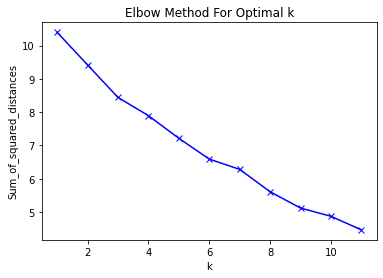

In [175]:
# Calculate the best K cluster number for the Clustering of Schools
manchester_grouped_clustering1 = manchester_grouped1.drop('Neighborhood', 1)

best_k_cluster(manchester_grouped_clustering1, 12)

In [176]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters1 = 9

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters1, random_state=0).fit(manchester_grouped_clustering1)

# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:10] 

array([0, 3, 0, 0, 1, 0, 0, 0, 0, 0])

#### Let's create a new dataframe that includes the cluster as well as the top 10 schools for each neighborhood.

In [177]:
# add clustering labels
neighborhoods_schools_sorted.insert(0, 'Cluster_Labels', kmeans1.labels_)
# neighborhoods_schools_sorted = neighborhoods_schools_sorted.assign(Cluster_Labels = kmeans.labels_.astype(int))

manchester_merged1 = manchester_nh_df

# merge manchester_grouped with manchester_nh_df to add latitude/longitude for each neighborhood
manchester_merged1 = manchester_merged1.join(neighborhoods_schools_sorted.set_index('Neighborhood'), on='Neighborhood')

manchester_merged1.head() # check the last columns!

,PostalCode,Town,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,M1,Manchester,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,0.0,Suja Driving School,La Suerte Dance School,Communicate School of English,Ef Summer School,School of Sound Recording (SSR),School of Psychological Sciences,"School of Mechanical, Aerospace & Civil Engine...",School of MACE,School of Electrical and Electronic Engineering,School of Chemical And Analytical Science
1,M2,Manchester,"Deansgate, City Centre",53.474096,-2.251063,0.0,Manjusri Secondary School,Manchester School of Architecture,Manchester School Of Arts,Manchester School Of Architecture,School of Design - Manchester Metropolitan Uni...,Benzie Building,Rolls Crescent Primary School,st johns school,King David School,Lewis Street Primary School
2,M4,Manchester,"Ancoats, Northern Quarter, Strangeways",53.484998,-2.227603,3.0,St. Patricks RC Primary School,st johns school,Manchest School of Theatre,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School,La Suerte Dance School
3,M8,Manchester,"Crumpsall, Cheetham Hill",53.520912,-2.241695,0.0,King David School,Abraham Moss High School,Cravenwood Primary School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training
4,M9,Manchester,"Harpurhey, Blackley",53.511907,-2.208449,0.0,Harpur Mount Primary School,Mount Carmel School,Holy Trinity CoE Primary School,Irk Valley Community School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School


### Finally, let's visualize the resulting clusters

In [178]:
# create map
import math
# Latitude and Longitude for the Manchester City/Town 
manchester_lat = 53.48095
manchester_lng = -2.23743
map_clusters1 = folium.Map(location=[manchester_lat, manchester_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters1)
ys = [i + x + (i*x)**2 for i in range(kclusters1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow.append('#000000')
print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manchester_merged1['Latitude'], manchester_merged1['Longitude'], manchester_merged1['Neighborhood'], manchester_merged1['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[len(rainbow) - 1 if math.isnan(cluster) else int(cluster)],
        fill=True,
        fill_color=rainbow[len(rainbow) - 1 if math.isnan(cluster) else int(cluster)],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

['#8000ff', '#4062fa', '#00b5eb', '#40ecd4', '#80ffb4', '#c0eb8d', '#ffb360', '#ff5f30', '#ff0000', '#000000']


## Examine Clusters for Schools

Cluster 1

In [179]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 0, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,"Piccadilly, City Centre, Market Street",0.0,Suja Driving School,La Suerte Dance School,Communicate School of English,Ef Summer School,School of Sound Recording (SSR),School of Psychological Sciences,"School of Mechanical, Aerospace & Civil Engine...",School of MACE,School of Electrical and Electronic Engineering,School of Chemical And Analytical Science
1,"Deansgate, City Centre",0.0,Manjusri Secondary School,Manchester School of Architecture,Manchester School Of Arts,Manchester School Of Architecture,School of Design - Manchester Metropolitan Uni...,Benzie Building,Rolls Crescent Primary School,st johns school,King David School,Lewis Street Primary School
3,"Crumpsall, Cheetham Hill",0.0,King David School,Abraham Moss High School,Cravenwood Primary School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training
4,"Harpurhey, Blackley",0.0,Harpur Mount Primary School,Mount Carmel School,Holy Trinity CoE Primary School,Irk Valley Community School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School
5,"Clayton, Openshaw, Beswick",0.0,higher openshaw community school,St Willibrords Primary School,Varna Community Primary School,st johns school,"Kilburn Building, School of Computer Science a...",Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School
6,"Ardwick, Longsight, Chorlton-on-Medlock",0.0,Chrysostom's Primary School,Alan Turing Building - School of Mathematics,The Arden Theatre School,School,"Kilburn Building, School of Computer Science a...",La Suerte Dance School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School
7,"Ardwick, Longsight, Chorlton-on-Medlock",0.0,Chrysostom's Primary School,Alan Turing Building - School of Mathematics,The Arden Theatre School,School,"Kilburn Building, School of Computer Science a...",La Suerte Dance School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School
8,"Fallowfield, Moss Side, Ladybarn, Rusholme, Vi...",0.0,Summer Medical School,Manchester High School,The Divine Mercy School,Manchester Grammar School Refectory,Manchester Grammar School,EF International Language Centres,Manchester Girls High School,Elite Swim School,Manchester High School for Girls,Wilbraham Primary School
9,"Hulme, Manchester Science Park, Old Trafford",0.0,manchester english school,Williamson Building,Manchester Dental School,International Medical Summer School,School Of Education (University Of Manchester),"School Of Social Sciences, the University Of M...",St Mary's C of E Primary School,Manchester Medical School,Divine Mercy Primary School,Trinity C of E High School
10,"Firswood, Old Trafford, Whalley Range, Moss Side",0.0,Manley Park Primary School Juniors,Oswald Road School,Manley Park Primary School Infants,Seymour Park Community Primary School,St John's RC Primary School,L-team Driving School,St Teresa's Primary School,Leap's Driving School,St. Hilda's C of E Primary School,Longford Park School


Cluster 2

In [180]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 1, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
17,"Baguley, Brooklands (Manchester and Trafford),...",1.0,Sandilands Primary School,Van Halen Driving School,Sale High School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School


Cluster 3

In [181]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 2, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
26,Stretford,2.0,Victoria Park Infant School,st johns school,King David School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School


Cluster 4

In [182]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 3, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
2,"Ancoats, Northern Quarter, Strangeways",3.0,St. Patricks RC Primary School,st johns school,Manchest School of Theatre,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School,La Suerte Dance School


Cluster 5

In [183]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 4, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
29,Little Hulton,4.0,Dukesgate Primary School,st johns school,Manchest School of Theatre,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School,La Suerte Dance School


Cluster 6

In [184]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 5, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
22,"Worsley, Walkden, Boothstown, Mosley Common, W...",5.0,Stagecoach Theatre Arts School,Bridgewater School,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School


Cluster 7

In [185]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 6, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
33,"Irlam, Cadishead",6.0,SIM Language School,Let's Learn School Of Motoring Ltd - ADI Training,st johns school,L-team Driving School,Longford Park School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Leap's Driving School


Cluster 8

In [186]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 7, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
32,Droylsden,7.0,St Stephens Nursery School,St. Mary's Primary School,st johns school,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School,La Suerte Dance School,L-team Driving School


Cluster 9

In [187]:
manchester_merged1.loc[manchester_merged1['Cluster_Labels'] == 8, manchester_merged1.columns[[2] + list(range(5,manchester_merged1.shape[1]))]]

,Neighborhood,Cluster_Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
36,Manchester X,8.0,Manchester Midi School,St. Peters and St Johns RC Primary School,st johns school,King David School,London School Of Barbering,Lindon Road Primary School,Lewis Street Primary School,Levenshulme High School,Let's Learn School Of Motoring Ltd - ADI Training,Leap's Driving School


## Deductions on Clusters for Schools in Neighbourhood

### 1. The first cluster had HIGH number of neighborhoods with HIGH number of schools which are of different degrees of availability per each neighborhood. 
### 2. Unlike the first cluster of neighborhoods, the eight other clusters have single neighborhoods which have unique characteristics.

# Exploring nearby Schools for Neighborhoods beyond 1000 meters

### Collating the list of Neighborhoods without Schools within the radius limit of 1000 meters

In [189]:
hood_per_km = sch_nh_df1.groupby('Neighborhood').count().reset_index()
hood_per_km['Neighborhood'] = hood_per_km['Neighborhood'].astype(str)
hood_per_km.shape

(33, 7)

In [190]:
print(manchester_nh_df.shape)
hoods_without_schools=[]
flag=0
for hood1 in manchester_nh_df['Neighborhood']:
    for hood2 in hood_per_km['Neighborhood']:
        if hood1==hood2:
            flag=1
            break
    if flag==0:
        hoods_without_schools.append(hood1)
    flag=0
print(len(hoods_without_schools))

(38, 5)
4


### These Neighborhoods had no schools available within 1000 meters radius

In [191]:
hoods_without_schools_df=pd.DataFrame(hoods_without_schools,columns=['Neighborhood'])
hoods_without_schools_df.shape

(4, 1)

In [192]:
# These Neighborhoods had no schools available within 1000 meters radius
hoods_without_schools_df

,Neighborhood
0,"Trafford Park, The Trafford Centre"
1,"Prestwich, Sedgley Park, Simister"
2,"Carrington, Partington"
3,Manchester Airport


In [193]:
# Create a new dataframe for these Neighborhoods with their respective lattitudes and longitudes
latude = []
lontude = []
for index, row in hoods_without_schools_df.iterrows():
    print("===={}.".format(index + 1))
    neighborhood_name = row["Neighborhood"]

    neighborhood_latlon = lat_lng_coordinates("", neighborhood_name)
    latude.append(neighborhood_latlon[0])
    lontude.append(neighborhood_latlon[1])
hoods_without_schools_df['Latitude'] = latude
hoods_without_schools_df['Longitude'] = lontude
hoods_without_schools_df.head()

====1.
Trafford Park
Neighborhood
2
[53.4717516, -2.3209276]
====2.
Prestwich
Neighborhood
2
[53.5304274, -2.2960186]
====3.
Carrington
Neighborhood
2
[47.44972, -99.126224]
====4.
Manchester Airport
Neighborhood
2
[53.350342049999995, -2.280369252664295]


,Neighborhood,Latitude,Longitude
0,"Trafford Park, The Trafford Centre",53.471752,-2.320928
1,"Prestwich, Sedgley Park, Simister",53.530427,-2.296019
2,"Carrington, Partington",47.449720,-99.126224
3,Manchester Airport,53.350342,-2.280369


### Find the radius to the nearest School for these Neighborhoods

In [194]:
limit=100
radius=1000
r=[]
k=[]
count=0
for name, lat, lng in zip(hoods_without_schools_df['Neighborhood'],hoods_without_schools_df['Latitude'],hoods_without_schools_df['Longitude']):
    while k==[] and count<10:
        count=count+1
        radius=radius + 100
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, limit)
        results = requests.get(url).json()
        k=results['response']['venues']
    r.append(radius)
    k=[]
    count=0
    radius=1000
print(r)

[1600, 1100, 1100, 1800]


In [195]:
# Merge the radius distance to the hoods_without_schools_df dataframe
hoods_without_schools_df['Sch_Radius'] = r
hoods_without_schools_df.head()

,Neighborhood,Latitude,Longitude,Sch_Radius
0,"Trafford Park, The Trafford Centre",53.471752,-2.320928,1600
1,"Prestwich, Sedgley Park, Simister",53.530427,-2.296019,1100
2,"Carrington, Partington",47.449720,-99.126224,1100
3,Manchester Airport,53.350342,-2.280369,1800


In [196]:
hoods_without_schools_df['Sch_in_1000m']=0
hoods_without_schools_df.head()

,Neighborhood,Latitude,Longitude,Sch_Radius,Sch_in_1000m
0,"Trafford Park, The Trafford Centre",53.471752,-2.320928,1600,0
1,"Prestwich, Sedgley Park, Simister",53.530427,-2.296019,1100,0
2,"Carrington, Partington",47.449720,-99.126224,1100,0
3,Manchester Airport,53.350342,-2.280369,1800,0


### Merge dataframes of Neighborhoods of Schools with Neighborhoods without schools within the 1000 meters radius

In [197]:
Merged_Hood_Radii_df = hoods_without_schools_df
Merged_Hood_Radii_df.shape

(4, 5)

In [198]:
# Radius within a 1000 meters range is set to 1000 meters radius
within_rad_df = sch_nh_df1.groupby(['Neighborhood','Latitude','Longitude']).count()
within_rad_df.reset_index()
for index,row in within_rad_df.iterrows():
        Merged_Hood_Radii_df=Merged_Hood_Radii_df.append({'Neighborhood':index[0],'Latitude':index[1],'Longitude':index[2],'Sch_Radius':1000,'Sch_in_1000m':row['School']},ignore_index=True)
Merged_Hood_Radii_df.shape

(37, 5)

### Perform a *K*-Means Clustering technique algorithm for 'Sch_Radius' and 'Sch_in_1000m' with the best number of clusters.

In [199]:
k_means_df = Merged_Hood_Radii_df[['Sch_Radius','Sch_in_1000m']]
k_means_df.head()

,Sch_Radius,Sch_in_1000m
0,1600,0
1,1100,0
2,1100,0
3,1800,0
4,1000,6


## Normalize the value using Standard Scalar

In [200]:
from sklearn.preprocessing import StandardScaler

X = k_means_df.values[:,:]
X = np.nan_to_num(X)
cluster_data = StandardScaler().fit_transform(X)
cluster_data

array([[ 3.47311611, -0.8620766 ],
       [ 0.35405553, -0.8620766 ],
       [ 0.35405553, -0.8620766 ],
       [ 4.72074035, -0.8620766 ],
       [-0.26975659,  0.18372124],
       [-0.26975659, -0.68777696],
       [-0.26975659,  0.0094216 ],
       [-0.26975659,  0.0094216 ],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.33917768],
       [-0.26975659,  0.35802088],
       [-0.26975659, -0.16487804],
       [-0.26975659,  0.35802088],
       [-0.26975659, -0.51347732],
       [-0.26975659,  0.18372124],
       [-0.26975659, -0.16487804],
       [-0.26975659,  1.22951909],
       [-0.26975659,  1.40381873],
       [-0.26975659, -0.16487804],
       [-0.26975659,  0.88091981],
       [-0.26975659, -0.51347732],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.68777696],
       [-0.26975659, -0.33917768],
       [-0.26975659, -0.33917768],
       [-0.26975659,

In [201]:
cluster_data.shape

(37, 2)

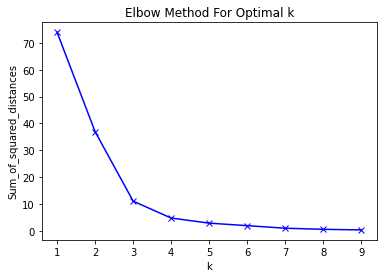

In [202]:
# Calculate the best K cluster number for the Clustering of Neighborhoods of Schools within and without 1000 metres radius
best_k_cluster(cluster_data, 10)

In [203]:
cluster_no = 3

k_means = KMeans(init="k-means++", n_clusters=cluster_no, n_init=12)
k_means.fit(cluster_data)
merge_labels = k_means.labels_

print(merge_labels)

[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]


### Fuse merged labels to the merged dataframe

In [204]:

# Merged_Hood_Radii_df=Merged_Hood_Radii_df.drop(['label','label_4'],axis=1)
Merged_Hood_Radii_df['label'] = merge_labels
Merged_Hood_Radii_df.head()


,Neighborhood,Latitude,Longitude,Sch_Radius,Sch_in_1000m,label
0,"Trafford Park, The Trafford Centre",53.471752,-2.320928,1600,0,1
1,"Prestwich, Sedgley Park, Simister",53.530427,-2.296019,1100,0,0
2,"Carrington, Partington",47.449720,-99.126224,1100,0,0
3,Manchester Airport,53.350342,-2.280369,1800,0,1
4,"Abbey Hey, Gorton",53.469858,-2.152198,1000,6,0


In [205]:
Merged_Hood_Radii_df.groupby('label').mean()

,Latitude,Longitude,Sch_Radius,Sch_in_1000m
label,,,,
0,53.303404,-5.121835,1005.882353,4.382353
1,53.411047,-2.300648,1700.000000,0.000000
2,53.479396,-2.231743,1000.000000,34.000000


## Separate the various labels as individual dataframes for Analyses

In [206]:
merged_label_df0 =Merged_Hood_Radii_df[Merged_Hood_Radii_df['label'] == 0]
merged_label_df1 =Merged_Hood_Radii_df[Merged_Hood_Radii_df['label'] == 1]
merged_label_df2 =Merged_Hood_Radii_df[Merged_Hood_Radii_df['label'] == 2]
print(merged_label_df0.shape,merged_label_df1.shape,merged_label_df2.shape)

(34, 6) (2, 6) (1, 6)


Cluster 1

In [207]:
merged_label_df0

,Neighborhood,Latitude,Longitude,Sch_Radius,Sch_in_1000m,label
1,"Prestwich, Sedgley Park, Simister",53.530427,-2.296019,1100,0,0
2,"Carrington, Partington",47.449720,-99.126224,1100,0,0
4,"Abbey Hey, Gorton",53.469858,-2.152198,1000,6,0
5,"Ancoats, Northern Quarter, Strangeways",53.484998,-2.227603,1000,1,0
6,"Ardwick, Longsight, Chorlton-on-Medlock",53.467675,-2.216010,1000,5,0
7,Atherton,53.524968,-2.490580,1000,5,0
8,"Baguley, Brooklands (Manchester and Trafford),...",53.406263,-2.304887,1000,3,0
9,"Chorlton-cum-Hardy, Barlow Moor",53.442508,-2.277211,1000,3,0
10,"Clayton, Openshaw, Beswick",53.479096,-2.173793,1000,3,0
11,"Collyhurst, Miles Platting, Moston, New Moston...",53.496005,-2.219933,1000,3,0


Cluster 2

In [208]:
merged_label_df1

,Neighborhood,Latitude,Longitude,Sch_Radius,Sch_in_1000m,label
0,"Trafford Park, The Trafford Centre",53.471752,-2.320928,1600,0,1
3,Manchester Airport,53.350342,-2.280369,1800,0,1


Cluster 3

In [209]:
merged_label_df2

,Neighborhood,Latitude,Longitude,Sch_Radius,Sch_in_1000m,label
28,"Piccadilly, City Centre, Market Street",53.479396,-2.231743,1000,34,2


## Deductions from Clusters for Neighborhoods nearest to School within and without 1000 meters radius

## Cluster 1
### Distance to the NEAREST Schools in these neighborhoods were within the 1000 meters radius with two neighborhoods slightly above 1000 meters and not more than 1100 meters. 
## Cluster 2
### The two neighborhoods, Trafford Park and Manchester Airport had their nearest schools far above 1000 meters with a radius of 1600 and 1800 respectively. 
## Cluster 3
### Piccadilly, City Centre, Market Street stands out among all the neighborhoods. The nearest schools were within the 1000 meter radius. Also, there were a good number of schools within this radius. 

In [214]:
# Latitude and Longitude for the Manchester City/Town 
manchester_lat = 53.48095
manchester_lng = -2.23743
manchester_map = folium.Map(location=[manchester_lat, manchester_lng], zoom_start=10)
incidents = folium.map.FeatureGroup()
for lat, lng, hood, swr, in zip(merged_label_df0['Latitude'],merged_label_df0['Longitude'],merged_label_df0['Neighborhood'],merged_label_df0['Sch_in_1000m']):
    label = folium.Popup(str(hood) + ': number of schools within 1000m: ' + str(swr), parse_html=True)
    incidents.add_child(
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
        )
    )
for lat, lng, hood, swr, in zip(merged_label_df1['Latitude'],merged_label_df1['Longitude'],merged_label_df1['Neighborhood'],merged_label_df1['Sch_in_1000m']):
    label = folium.Popup(str(hood) + ': number of schools within 1000m: ' + str(swr), parse_html=True)
    incidents.add_child(
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill = True,
        fill_color='green',
        fill_opacity=0.6
        )
    )
for lat, lng, hood, swr,in zip(merged_label_df2['Latitude'],merged_label_df2['Longitude'],merged_label_df2['Neighborhood'],merged_label_df2['Sch_in_1000m']):
    label = folium.Popup(str(hood) + ': number of schools within 1000m: ' + str(swr), parse_html=True)
    incidents.add_child(
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.6
        )
    )
# add incidents to map
manchester_map.add_child(incidents)
manchester_map
